In [1]:
import gym
import d4rl # Import required to register environments
# import time 
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

These new versions include large bug fixes, new versions of Python, and are where all new development will continue. Please upgrade these libraries as soon as you're able to do so.
If you'd like to read more about the story behind this switch, please check out ]8;;https://farama.org/Announcing-Minari\this blog post]8;;\.
/home/utsab/miniconda3/envs/IRL_AGV/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
No module named 'flow'
No module named 'carla'
pybullet build time: Nov 28 2023 23:45:17


In [2]:
env = gym.make("hopper-expert-v0")
dataset = env.get_dataset()

/home/utsab/miniconda3/envs/IRL_AGV/lib/python3.10/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment hopper-expert-v0 is out of date. You should consider upgrading to version `v2` with the environment ID `hopper-expert-v2`.
  logger.warn(
/home/utsab/miniconda3/envs/IRL_AGV/lib/python3.10/site-packages/d4rl/gym_mujoco/gym_envs.py:13: UserWarning: This environment is deprecated. Please use the most recent version of this environment.
  offline_env.OfflineEnv.__init__(self, **kwargs)
/home/utsab/miniconda3/envs/IRL_AGV/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.10it/s]


In [3]:
len(dataset['observations'])

1000000

In [4]:
data_array = np.array(dataset["rewards"][:10000])
neg_array = data_array[data_array<0]
neg_array.size

0

In [5]:
observations = torch.tensor(dataset['observations'])[:10000]
mean = observations.mean(dim=0)
std = observations.std(dim=0)
observations = (observations - mean)/std
actions = torch.tensor(dataset['actions'])[:10000]
# data = TensorPairDataset(observations,actions)

In [6]:
observations

tensor([[-0.7744,  0.7826,  2.3278,  ...,  0.0355,  0.0036, -0.0113],
        [-0.7768,  0.8052,  2.3472,  ...,  0.2680, -0.2564,  0.1914],
        [-0.7831,  0.7728,  2.3604,  ...,  0.1356, -0.6247,  0.2166],
        ...,
        [ 1.3501, -0.4600,  0.7185,  ..., -0.8782,  0.6239,  1.1158],
        [ 1.3850, -0.5587,  0.6150,  ..., -1.5694,  0.8177,  1.1408],
        [ 1.4168, -0.6333,  0.5020,  ..., -1.1095,  1.2184,  1.2135]])

In [7]:
env.reset()

array([ 1.245726  , -0.00207956,  0.00474384, -0.00398621,  0.00400737,
       -0.00434266, -0.00207992, -0.00230586,  0.00216814,  0.00272276,
        0.00445003])

In [23]:
dataset_N = {"observations":dataset["observations"][:10000],"actions":dataset["actions"][:10000]}
new_dataset = [dict(zip(dataset_N.keys(), values)) for values in zip(*dataset_N.values())]

# Print result
# print(new_dataset)


In [24]:
class P_Network(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.network_m = nn.Sequential(nn.Linear(input_size,24),
                                     nn.Tanh(),
                                     nn.Linear(24,8),
                                     nn.Tanh(),
                                     nn.Linear(8,3))                                     
        self.network_s = nn.Sequential(nn.Linear(input_size,24),
                                     nn.Tanh(),
                                     nn.Linear(24,8),
                                     nn.Tanh(),
                                     nn.Linear(8,3))      
    def forward(self,state):
        self.mean = self.network_m(state)
        self.std = F.softplus(self.network_s(state)) + 1e-6
        # print(self.mean,self.std)
        
        normal_dist = torch.distributions.Normal(self.mean,self.std)
        raw_action = normal_dist.rsample()  # Use reparameterization trick
        
        # Map action to [-1, 1] using tanh
        action = torch.clamp(raw_action,min=-1,max=1)
        # print(self.mean,self.std)
        # Compute log probability of the sampled action
        log_prob = normal_dist.log_prob(raw_action) 
        # print(log_prob)
        log_prob = log_prob.sum(dim=-1, keepdim=True)  # Sum over action dimensions
        # print(action)
        
        return action, log_prob

        
                    
           

In [83]:
class PM_Network(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.action_network = nn.Sequential(nn.Linear(input_size,24),
                                     nn.Tanh(),
                                     nn.Linear(24,8),
                                     nn.Tanh(),
                                     nn.Linear(8,3),
                                     nn.Tanh())                                     
        self.prob_network = nn.Sequential(nn.Linear(input_size,24),
                                     nn.Tanh(),
                                     nn.Linear(24,8),
                                     nn.Tanh(),
                                     nn.Linear(8,3),
                                     nn.Sigmoid())      
    def forward(self,state):
        
        
        # Map action to [-1, 1] using tanh
        action = self.action_network(state)
        log_prob = torch.log(self.prob_network(state) )
        
        log_prob = log_prob.sum(dim=-1, keepdim=True)  # Sum over action dimensions
        # print(action)
        
        return action, log_prob

        
                    
           

In [96]:
class D_Network(nn.Module):
    def __init__(self,input_size):
        super(D_Network,self).__init__()
        self.network = nn.Sequential(nn.Linear(input_size,24),
                                     nn.Tanh(),
                                     nn.Linear(24,16),
                                     nn.Tanh(),
                                     nn.Linear(16,4),
                                     nn.Tanh(),
                                     nn.Linear(4,1),
                                     nn.Sigmoid())
    def forward(self,state,action):
        # print(state,action)
        # print("State shape:", state.shape, "Action shape:", action.shape)
        x = torch.cat((state, action.detach()), dim=-1)
        # print("combined input",x)
        self.output = self.network(x.float())

        return self.output
    
        



In [125]:
Policy = PM_Network(11,3)

In [126]:
Discriminator = D_Network(14)

In [130]:
import random
from IPython.display import clear_output
import time
import copy

In [133]:
def compute_kl_divergence(p_network_old, p_network_new, states):
    with torch.no_grad():
        old_probs = p_network_old.prob_network(states)
    new_probs = p_network_new.prob_network(states)
    
    kl = (old_probs * (torch.log(old_probs + 1e-8) - torch.log(new_probs + 1e-8))).sum(dim=-1)
    return kl.mean()

def train(dataset, epochs, traj_no, max_steps, P_network, D_network, lr_D, lr_P, lamda, beta, opt_func=torch.optim.Adam):
    state = torch.from_numpy(env.reset())
    
    D_losses = []
    P_losses = []
    KL_losses = []
    
    expert_trajectories = []
    for t in range(traj_no):
        idx = random.randint(0, len(dataset) - max_steps)
        expert_trajectories.append(dataset[idx:idx + max_steps])

    for epoch in range(epochs):
        Ex_aD_loss, Ex_eD_loss, Ex_P_loss, Ex_H_loss = 0, 0, 0, 0
        sample_trajectories = []

        # Clone the current policy network for KL divergence calculation
        P_network_old = PM_Network(11,3)
        P_network_old.load_state_dict(P_network.state_dict())
        P_network_old.eval()
        
        for path in range(traj_no):
            state = torch.from_numpy(env.reset())
            aD_loss, eD_loss, H_loss = 0, 0, 0
            current_trajectory = []
            
            for step in range(1, max_steps):
                action, log_prob = P_network(state.float())
                current_trajectory.append({"state": state, "actions": action, "log_prob": log_prob})
                
                temp_action = action
                next_state, reward, done, info = env.step(np.array(temp_action.detach()))
                
                exp_state = torch.Tensor(expert_trajectories[path][step]["observations"])
                exp_action = torch.Tensor(expert_trajectories[path][step]["actions"])
                
                aD_loss += torch.log(D_network(state.detach(), action.detach()) + 1e-8)
                eD_loss += torch.log(1 - D_network(exp_state, exp_action) + 1e-8)

                H_loss -= log_prob * torch.exp(log_prob).item()
                
                if done or step == max_steps - 1:
                    break
                state = torch.from_numpy(next_state)
            
            sample_trajectories.append(current_trajectory)
            Ex_aD_loss += aD_loss
            Ex_eD_loss += eD_loss
            Ex_H_loss += H_loss
        
        ### Update Discriminator ###
        Ex_aD_loss /= traj_no
        Ex_eD_loss /= traj_no
        total_D_loss = -(Ex_aD_loss + Ex_eD_loss)
        
        opt_D = opt_func(D_network.parameters(), lr_D)
        opt_D.zero_grad()
        total_D_loss.backward()
        opt_D.step()
        
        # -------------- Update Policy -------------- 
Ex_P_loss = 0
all_states = []
all_old_log_probs = []
all_advantages = []

for traj in sample_trajectories:
    traj_P_loss = 0
    for idx, step in enumerate(traj):
        Q = 0.1
        for jdx in range(idx + 1, len(traj)):
            temp = D_network(traj[jdx]['state'].detach(), traj[jdx]['actions'].detach())
            Q += torch.log(temp + 1e-8).item()
        
        advantage = Q
        all_advantages.append(advantage)
        
        all_states.append(step['state'].float().unsqueeze(0))  # For KL calculation
        all_old_log_probs.append(step['log_prob'].detach().unsqueeze(0))  # Save old log_probs
        
Ex_P_loss /= traj_no
all_states = torch.cat(all_states, dim=0)
all_old_log_probs = torch.cat(all_old_log_probs, dim=0)
all_advantages = torch.tensor(all_advantages, dtype=torch.float32).unsqueeze(1)

# Now recompute new log_probs with updated P_network
new_actions, new_log_probs = P_network(all_states)

# Compute the ratio
ratios = torch.exp(new_log_probs - all_old_log_probs)

# PPO clipped surrogate loss
surr1 = ratios * all_advantages
surr2 = torch.clamp(ratios, 1 - clip_eps, 1 + clip_eps) * all_advantages
policy_loss = -torch.min(surr1, surr2).mean()

# KL divergence (optional, for monitoring)
kl_div = compute_kl_divergence(P_network_old, P_network, all_states)

total_P_loss = policy_loss + lamda * Ex_H_loss + beta * kl_div

opt_P = opt_func(P_network.parameters(), lr_P)
opt_P.zero_grad()
total_P_loss.backward()
opt_P.step()

        D_losses.append(total_D_loss.detach().item())
        P_losses.append(total_P_loss.detach().item())
        KL_losses.append(kl_div.detach().item())

        clear_output(wait=True)
        plt.plot(D_losses, label='Discriminator Loss')
        plt.plot(P_losses, label='Policy Loss')
        plt.plot(KL_losses, label='KL Divergence')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.grid(True)
        plt.legend()
        plt.show()
        time.sleep(0.1)

    return D_losses, P_losses, KL_losses


In [100]:

def train(dataset,epochs,traj_no,max_steps,P_network,D_network,lr_D,lr_P,lamda,opt_func=torch.optim.SGD):
    state = torch.from_numpy(env.reset())
    # print(state.dtype)
    expert_trajectories =[]
    D_losses = []
    P_losses = []
    for t in range(traj_no):
        idx = random.randint(0,len(dataset)-max_steps)
        expert_trajectories.append(dataset[idx:idx+max_steps])

    for epoch in range(epochs):
        # print("Epoch No:",epoch)
        Ex_aD_loss = 0
        Ex_eD_loss = 0
        Ex_P_loss =0 
        Ex_H_loss=0
        # Trajectory Sampling
        sample_trajectories =[]
        for path in range(traj_no):
            state = torch.from_numpy(env.reset())
            aD_loss=0
            eD_loss=0
            H_loss=0
            current_trajectory=[]
            for step in range(1,max_steps):
                
                action, log_prob = P_network(state.float())
                current_trajectory.append({"state":state,"actions":action,"log_prob":log_prob})
                temp_action = action
                next_state,reward,done,info = env.step(np.array(temp_action.detach()))

                exp_state = torch.Tensor(expert_trajectories[path][step]["observations"])
                exp_action = torch.Tensor(expert_trajectories[path][step]["actions"])
                
                aD_loss += torch.log(D_network(state.detach(),action.detach())+1e-8)
                eD_loss += torch.log(1- D_network(exp_state,exp_action)+1e-8)

                H_loss-=log_prob*torch.exp(log_prob).item()
                
                if done or step==max_steps-1:
                    # eD_loss /= step
                    # aD_loss /= step
                    # P_loss /= step
                    break
                state = torch.from_numpy(next_state)
                
            sample_trajectories.append(current_trajectory)
                    

            Ex_aD_loss+=aD_loss
            Ex_eD_loss+=eD_loss
            Ex_H_loss += H_loss
        
        ### Updating Discriminator 
        # print("XX============UPDATE DISCRIMINATOR===============XX")
        Ex_aD_loss/=traj_no
        Ex_eD_loss/=traj_no
        total_D_loss = -(Ex_aD_loss + Ex_eD_loss)
        
        
        opt_D = opt_func(D_network.parameters(),lr_D)
        # print(Ex_aD_loss,Ex_eD_loss)
        # print("total D loss",total_D_loss)
        # print(list(D_network.parameters()))
        total_D_loss.backward()
        opt_D.step()
        opt_D.zero_grad()

        
        ## Updating the Policy
        # print("XX================UPDATE POLICY======================XX")
        Ex_P_loss=0
        
        for traj in sample_trajectories:
            traj_P_loss=0
            for idx,step in enumerate(traj):
                Q=0.1
                for jdx in range(idx+1,len(traj)):
                    temp = D_network(traj[jdx]['state'].detach(),traj[jdx]['actions'].detach())
                    # print("temp",temp)
                    Q+=torch.log(temp).item()
                    
                # print("Q:",Q)
                traj_P_loss-=step['log_prob']*Q
            
            Ex_P_loss+=traj_P_loss
        
                
        Ex_P_loss/=traj_no
        # Ex_H_loss/=traj_no
        # Ex_H_loss/=traj_no
        total_P_loss = (Ex_P_loss) + lamda*Ex_H_loss 
        # print("PLOss:",total_P_loss)
        opt_P = opt_func(P_network.parameters(),lr_P)
        total_P_loss.backward()
        opt_P.step()
        opt_P.zero_grad()
        # print("P descent happened!!")
        D_losses.append(total_D_loss.detach())
        P_losses.append(total_P_loss.detach())

        clear_output(wait=True)
    
        # Plot the losses
        plt.plot(D_losses, label='Discriminator Loss')
        plt.plot(P_losses, label='Policy Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Losses')
        plt.grid(True)
        plt.legend()
        plt.show()
    
        # Simulate time delay (you can remove this)
        time.sleep(0.1)

    return D_losses,P_losses
        
    
    

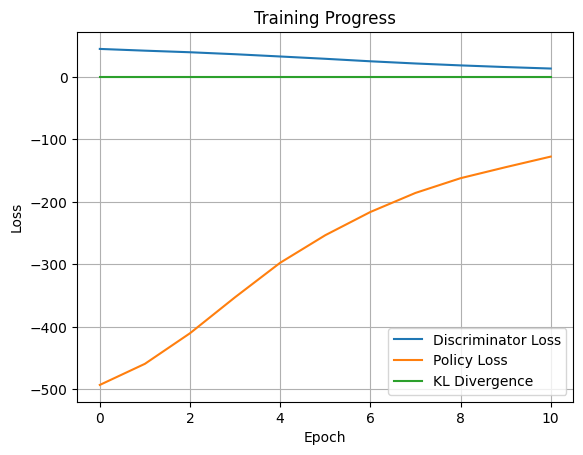

KeyboardInterrupt: 

In [134]:
train(new_dataset,200,5,300,Policy,Discriminator,1e-2,1e-4,0.01,0.01)

In [103]:
env.action_space

Box(-1.0, 1.0, (3,), float32)

In [120]:
def test(model,D_network,episodes):
    env = gym.make("hopper-expert-v0")
    # state,info = env.reset()
    state = torch.from_numpy(env.reset())
    total_reward=0
    D_loss =0
    for ep in range(episodes):
       
        action, log_prob = model(state.float())
        temp_action = action
        next_state,reward,done,info = env.step(np.array(temp_action.detach()))
        D_loss += torch.log(D_network(state.detach(),action.detach())+1e-8).item()
        total_reward+=reward
        if done or ep==episodes-1:
            print(total_reward,ep)
            
            break
        state = torch.from_numpy(next_state)    
    env.close()
    return total_reward

In [121]:
gail_history=[]
for i in range(200):
    gail_history.append(test(Policy,Discriminator,200))

7.27140461517394 34
7.489139334621018 34
7.3194478914900785 34
7.290525079691619 34
8.523768481144204 32
7.372661620948943 34
7.530699838178168 34
7.347728152441604 34
7.647297612459294 34
8.090804527632129 33
7.4854152289885425 34
7.531408573995657 33
8.73045636602083 32
7.737745144945565 33
7.3622326907572795 34
7.432675805804638 34
7.832320789718351 33
7.048699510075149 34
7.876926826024551 33
8.154063247943276 33
7.260667846231558 34
7.359215558351282 34
6.98539763555177 34
7.433557671394009 33
7.654049436883926 33
7.862061673132711 33
8.396939405539273 32
6.632645816153651 34
6.905805493670977 34
7.166596526478372 34
8.195582431485857 33
6.946575112323812 34
7.498821358210915 34
7.986635409455441 33
7.629574219820583 33
7.250907379815873 34
7.093884017219823 34
7.278002154722623 34
7.055491969996559 34
6.9184589782878945 34
7.996269647070031 33
7.542161058432162 33
8.328566649564435 32
8.117299535992053 32
8.535852543467014 32
7.752085979896077 33
6.881813167956823 34
6.7906900001

In [106]:
Policy_random = PM_Network(11,3)
D_random = D_Network(14)

In [107]:
random_history=[] 
for i in range(200):
    random_history.append(test(Policy_random,D_random,200))

10.29421974811112 37
9.779905759707189 38
10.003732627251388 38
9.75388610794409 38
9.450590371743878 39
9.75197929158509 38
10.052226337790557 38
9.751303726770217 38
10.015658943746908 38
10.124811622286726 37
9.743515331028735 39
9.952051115835625 38
9.699004604015117 38
10.403016909650223 37
9.89349787139567 38
9.986404948823969 38
9.943304518286048 38
9.638711595222633 39
9.826599918339433 38
9.623207213376041 38
10.122288395926127 37
10.060717285881324 38
10.273798027944004 37
9.560516635906918 38
9.749810684125753 38
10.203462678442449 37
10.342753633429943 37
10.076651709005885 37
10.483680207789801 37
9.939289988489982 38
10.177430142290088 37
10.625506156212031 36
10.234026022116335 37
10.155715913893193 37
9.710355216281334 38
9.350049906130204 39
9.138791646691194 39
10.115014168240178 37
10.153770919599369 37
10.203236695274436 37
9.82923640485728 38
9.571216414002363 39
9.588804304486569 38
10.176426255592194 37
10.171873794312287 37
9.378158918094622 39
9.843130619950207

In [108]:
import matplotlib.pyplot as plt
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
def plot_two_series(y1, y2, x_label='Episodes', y_label='Total Reward', title='Graph of Two Series', legend1='Gail', legend2='No Gail'):
    x = range(len(y1))  # Assumes y1 and y2 have the same length
    plt.figure(figsize=(10, 5))
    window_size=5
    smoothed_y1 = moving_average(y1, window_size)
    smoothed_y2 = moving_average(y2, window_size)
    x_smooth = range(window_size - 1, len(y1))  # Adjust x for smoothed data
    
    plt.plot(x_smooth, smoothed_y1, label=f'{legend1} (SMA-{window_size})', color='blue', linewidth=2)
    plt.plot(x_smooth, smoothed_y2, label=f'{legend2} (SMA-{window_size})', color='orange', linewidth=2)
    # plt.plot(x, y1, label=legend1, marker='o')
    # plt.plot(x, y2, label=legend2, marker='x')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


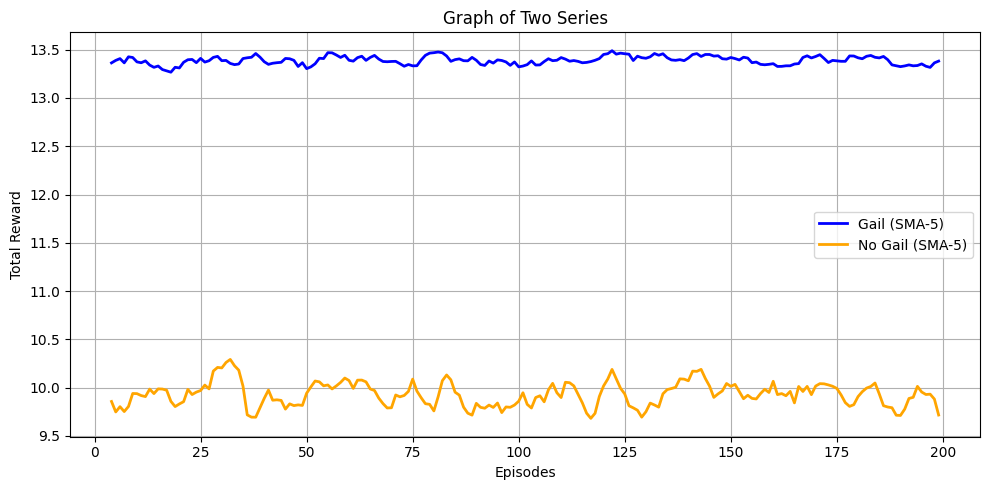

In [109]:
plot_two_series(gail_history,random_history)